In [1]:
############################################################
# Contents of the tutorial:
# Part I) Saving model checkpoints to support early stopping
# Part II) Extract features using an ImageNet models: VGG
# Part III) Fine-tune an ImageNet model: VGG
#############################################################

In [2]:
# Part 1: Early stopping + saving model checkpoints
# Imports
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

from tensorflow.keras.utils import to_categorical

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
#2: base model
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([Conv2D(64, 3, 1, activation='relu', input_shape=(28, 28, 1)),
                   Dropout(0.1),
                   MaxPooling2D((2,2)),
                   Flatten(),
                   Dense(10, activation='softmax')
                   ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                108170    
Total params: 108,810
Trainable params: 108,810
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

trained_base_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 36s 38ms/step - loss: 0.9568 - accuracy: 0.9376 - val_loss: 0.1030 - val_accuracy: 0.9722
Epoch 2/5
938/938 [==============================] - 36s 38ms/step - loss: 0.0813 - accuracy: 0.9764 - val_loss: 0.0927 - val_accuracy: 0.9738
Epoch 3/5
938/938 [==============================] - 36s 38ms/step - loss: 0.0586 - accuracy: 0.9821 - val_loss: 0.1076 - val_accuracy: 0.9712
Epoch 4/5
938/938 [==============================] - 36s 38ms/step - loss: 0.0521 - accuracy: 0.9838 - val_loss: 0.1025 - val_accuracy: 0.9738
Epoch 5/5
938/938 [==============================] - 36s 38ms/step - loss: 0.0496 - accuracy: 0.9848 - val_loss: 0.1185 - val_accuracy: 0.9716


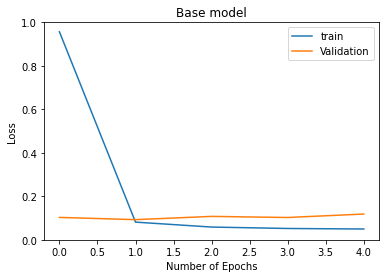

In [5]:
#3. Plot base model
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trained_base_model.history['loss'], label='train')
plt.plot(trained_base_model.history['val_loss'], label='Validation')
plt.ylim(0,1)
plt.title('Base model')
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

In [6]:
#4. Early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([Conv2D(64, 3, 1, activation='relu', input_shape=(28, 28, 1)),
                   Dropout(0.1),
                   MaxPooling2D((2,2)),
                   Flatten(),
                   Dense(10, activation='softmax')
                   ])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model)tutorial.h5', monitor='val_loss', mode='min', save_best_only=True)
trained_model_es = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[es, mc])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                108170    
Total params: 108,810
Trainable params: 108,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
938/938 [==============================] - 36s 39ms/step - loss: 0.9303 - accuracy: 0.9388 - val_loss: 

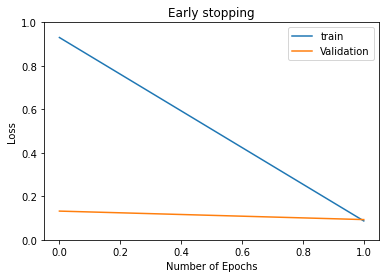

In [7]:
#5 Plotting

plt.figure()
plt.plot(trained_model_es.history['loss'], label='train')
plt.plot(trained_model_es.history['val_loss'], label='Validation')
plt.ylim(0,1)
plt.title('Early stopping')
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

In [8]:
#6. Load saved model
from tensorflow.keras.models import *

saved_model = load_model("best_model)tutorial.h5")
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print(f"Train: {train_acc:.3f}, Test: {test_acc:.3f}")

Train: 0.986, Test: 0.976


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

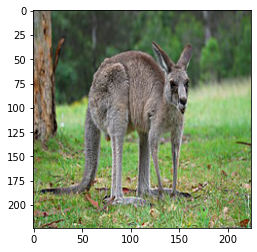

In [17]:
# Part 2: Extract features using VGG16

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.preprocessing import image

vgg_model = VGG16(weights="imagenet", include_top=False)
vgg_model.summary()

# Call image from a url
from PIL import Image
from urllib import request
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Kangaroo_Australia_01_11_2008_-_retouch.JPG/330px-Kangaroo_Australia_01_11_2008_-_retouch.JPG"
res = request.urlopen(url).read()
img = Image.open(BytesIO(res)).resize((224, 224))
plt.imshow(img)

In [18]:
#2. Extract features
# pre process

img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg_feature_maps = vgg_model.predict(img_data)
print(vgg_feature_maps.shape)

(1, 7, 7, 512)


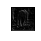

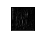

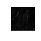

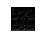

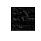

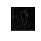

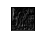

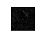

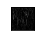

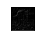

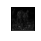

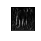

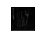

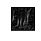

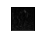

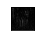

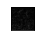

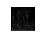

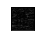

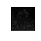

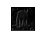

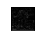

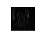

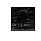

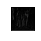

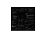

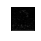

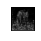

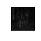

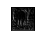

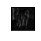

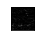

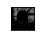

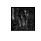

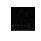

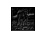

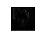

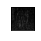

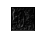

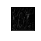

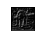

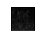

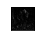

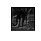

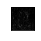

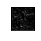

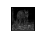

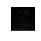

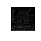

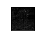

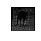

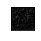

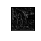

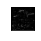

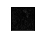

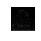

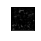

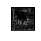

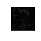

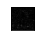

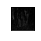

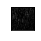

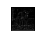

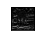

In [21]:
#3. Visualize the feature maps

from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[5].output)

feature_maps = model.predict(img_data)
square = 8
ix = 1
plt.figure()
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap = 'gray')
        ix+=1

        plt.show()

In [23]:
# Part 3: Fine tune VGG model

#1. Load CIFAR-10 dataset
import cv2
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[0:2000]
y_train = y_train[0:2000]

X_test = X_test[0:200]
y_test = y_test[0:200]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# X_train = X_train.reshape(X_train[0], 32, 32, 3)
# X_test = X_test.reshape(X_test[0], 32, 32, 3)

In [25]:
## 2. Unfreeze the last two layers to finetune the model

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [27]:
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_8 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True


In [29]:
from tensorflow.keras.layers import *

headModel = vgg_model.output

x = Flatten()(headModel)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [30]:
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

0 input_8 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True


In [31]:
checkpoint = ModelCheckpoint("vgg16_finetune.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

transfer_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

history = transfer_model.fit(X_train, y_train, batch_size=256, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
8/8 [==============================] - 11s 1s/step - loss: 25.5355 - accuracy: 0.2500 - val_loss: 9.0063 - val_accuracy: 0.3750
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 10.0960 - accuracy: 0.3985 - val_loss: 5.6840 - val_accuracy: 0.4650
Epoch 3/30
8/8 [==============================] - 9s 1s/step - loss: 4.7485 - accuracy: 0.4620 - val_loss: 3.1068 - val_accuracy: 0.3900
Epoch 4/30
8/8 [==============================] - 9s 1s/step - loss: 2.6682 - accuracy: 0.4220 - val_loss: 2.2032 - val_accuracy: 0.3950
Epoch 5/30
8/8 [==============================] - 9s 1s/step - loss: 1.9888 - accuracy: 0.4390 - val_loss: 2.3619 - val_accuracy: 0.3350
Epoch 6/30
8/8 [==============================] - 11s 1s/step - loss: 1.7476 - accuracy: 0.4850 - val_loss: 2.0929 - val_accuracy: 0.3400
Epoch 7/30
8/8 [==============================] - 8s 1s/step - loss: 1.4851 - accuracy: 0.5230 - val_loss: 2.2663 - val_accuracy: 0.3850
Epoch 8/30
8/8 [=====================